# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator, VOCS

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-02 23:01:44 - xopt.generator - INFO - Initialized generator nsga2
2025-03-02 23:01:44 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-02 23:01:44 - xopt.base - INFO - Running Xopt step
2025-03-02 23:01:44 - xopt.generators.deduplicated - INFO - generated 50 candidates in 2.72ms (removed 0 duplicate individuals)
2025-03-02 23:01:44 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 23:01:44 - xopt.generators.ga.nsga2 - INFO - completed generation 1 in 0.020s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-02 23:01:44 - xopt.base - INFO - Running Xopt step
2025-03-02 23:01:44 - xopt.generators.deduplicated - INFO - generated 50 candidates in 10.59ms (removed 0 duplicate individuals)
2025-03-02 23:01:44 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 23:01:44 - xopt.generators.ga.nsga2 - INFO - completed generation 2 in 0.022s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)
2025-03-02 23:01:44

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 875 ms
Wall time: 964 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.021635,0.319323,0.567419,0.866308,0.763183,0.410990,0.300346,0.721355,0.055815,0.387913,...,0.590510,0.745652,0.252397,0,4,0.021635,4.532045,4.870243,0.000040,False
1,0.027766,0.297526,0.998124,0.419148,0.729550,0.129212,0.176884,0.243299,0.098649,0.212915,...,0.757067,0.072147,0.325542,0,24,0.027766,4.860440,5.264010,0.000013,False
2,0.028723,0.449290,0.322545,0.543925,0.548529,0.279657,0.373527,0.654028,0.087915,0.806282,...,0.157116,0.753658,0.093773,0,19,0.028723,4.892822,5.305743,0.000009,False
3,0.070815,0.201645,0.101685,0.459456,0.947510,0.993247,0.350038,0.346404,0.478794,0.894615,...,0.322152,0.536001,0.689942,0,28,0.070815,5.204827,5.907842,0.000008,False
4,0.071244,0.435963,0.150748,0.859965,0.093207,0.849565,0.414533,0.316897,0.045084,0.768430,...,0.779256,0.894371,0.529788,0,6,0.071244,5.016630,5.710420,0.000009,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2472, 2448, 2461, 2460, 2471, 2324, 2446, 2442, 2457, 2490, 2422, 2369, 2462, 2466, 2258, 2368]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.021635,0.319323,0.567419,0.866308,0.763183,0.410990,0.300346,0.721355,0.055815,0.387913,...,0.590510,0.745652,0.252397,0,4,0.021635,4.532045,4.870243,0.000040,False
1,0.027766,0.297526,0.998124,0.419148,0.729550,0.129212,0.176884,0.243299,0.098649,0.212915,...,0.757067,0.072147,0.325542,0,24,0.027766,4.860440,5.264010,0.000013,False
2,0.028723,0.449290,0.322545,0.543925,0.548529,0.279657,0.373527,0.654028,0.087915,0.806282,...,0.157116,0.753658,0.093773,0,19,0.028723,4.892822,5.305743,0.000009,False
3,0.070815,0.201645,0.101685,0.459456,0.947510,0.993247,0.350038,0.346404,0.478794,0.894615,...,0.322152,0.536001,0.689942,0,28,0.070815,5.204827,5.907842,0.000008,False
4,0.071244,0.435963,0.150748,0.859965,0.093207,0.849565,0.414533,0.316897,0.045084,0.768430,...,0.779256,0.894371,0.529788,0,6,0.071244,5.016630,5.710420,0.000009,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

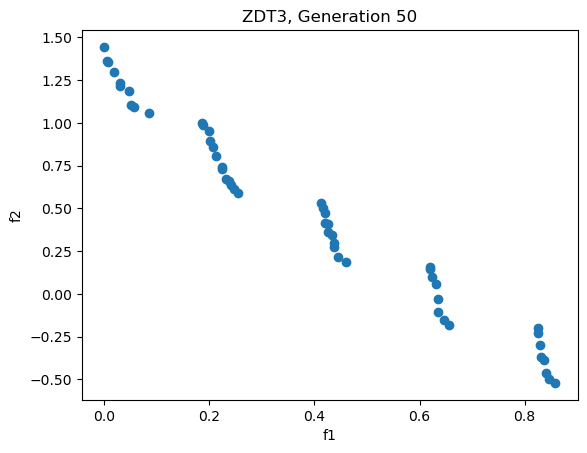

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `vocs.txt`: The VOCS object so that the objectives, constraints, decision variables are retained alongside the data
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmpnmhe93br"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # How often (in terms of generations) should we save the optimizer state?
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmpnmhe93br": ['checkpoints', 'data.csv', 'populations.csv', 'vocs.txt']
"checkpoints": ['20250302_230145_1.txt', '20250302_230145_2.txt', '20250302_230146_1.txt', '20250302_230146_2.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

# Clean up the directory
shutil.rmtree(X.generator.output_dir)

Requested path: "C:\Users\chris\AppData\Local\Temp\tmpnmhe93br"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmpnmhe93br_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.015927,0.199584,0.888487,0.345046,0.911836,0.861837,0.505839,0.135018,0.317667,0.603503,...,0.329331,0.231931,0.874262,0,49,0.015927,5.525815,5.838397,0.000028,False
1,0.056075,0.040121,0.467463,0.814892,0.104844,0.639156,0.990683,0.072090,0.882566,0.064001,...,0.050846,0.821675,0.190551,0,17,0.056075,4.522456,5.112965,0.000010,False
2,0.079881,0.903047,0.499161,0.982198,0.700735,0.110126,0.884217,0.140184,0.129665,0.618410,...,0.469730,0.819777,0.287034,0,6,0.079881,5.595601,6.355304,0.000009,False
3,0.086113,0.497262,0.694013,0.029839,0.966368,0.844518,0.365368,0.856351,0.575105,0.590843,...,0.852155,0.119279,0.593167,0,14,0.086113,5.308189,6.067408,0.000008,False
4,0.092578,0.418510,0.667547,0.305322,0.436210,0.550224,0.660438,0.959175,0.392838,0.327083,...,0.434278,0.964559,0.639879,0,41,0.092578,4.869571,5.611742,0.000008,False


In [16]:
# Read the VOCS object back in. This can be used for data analysis / restarting optimizations
with open(os.path.join(generator.output_dir, "vocs.txt")) as f:
    vocs_from_file = VOCS.from_dict(json.load(f))

# Show the objectives
vocs_from_file.objectives

{'f1': 'MINIMIZE', 'f2': 'MINIMIZE'}

In [17]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,0.000108,0.054063,0.119615,0.342501,0.168027,0.025344,0.027404,0.059818,0.019092,0.002195,...,0.021529,0.262004,31,1550,0.000108,2.008503,2.023305,0.000010,False,32
1551,0.652321,0.054005,0.108276,0.303643,0.096524,0.017744,0.040572,0.065164,0.057315,0.054172,...,0.021076,0.166805,30,1525,0.652321,0.180163,1.962081,0.000007,False,32
1552,0.264182,0.046068,0.108505,0.339456,0.166401,0.000390,0.032811,0.064278,0.037922,0.015928,...,0.028180,0.077180,29,1452,0.264182,0.970386,1.921202,0.000008,False,32
1553,0.441036,0.046068,0.104308,0.339729,0.221375,0.093104,0.019270,0.064236,0.037076,0.013243,...,0.027771,0.251518,31,1582,0.441036,0.694627,2.074905,0.000008,False,32
1554,0.415414,0.057283,0.108863,0.246044,0.096417,0.018614,0.037016,0.010422,0.006466,0.033501,...,0.026582,0.171955,29,1499,0.415414,0.878586,1.978585,0.000008,False,32


In [18]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

# Clean up the output
shutil.rmtree(X.generator.output_dir)

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [19]:
# Clean up the original output
shutil.rmtree(output_dir)